<a href="https://colab.research.google.com/github/alimirash/RNN_Forex_Price_Prediction/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
# Define the column names for your DataFrame
columns = ["Date","Open","High","Low","Close","Volume"]

# Read the CSV file into a DataFrame and convert the 'Date' column to datetime
df = pd.read_csv("/content/sample_data/EURUSD_M15.csv", names =columns)
df['Date'] = pd.to_datetime(df['Date'])

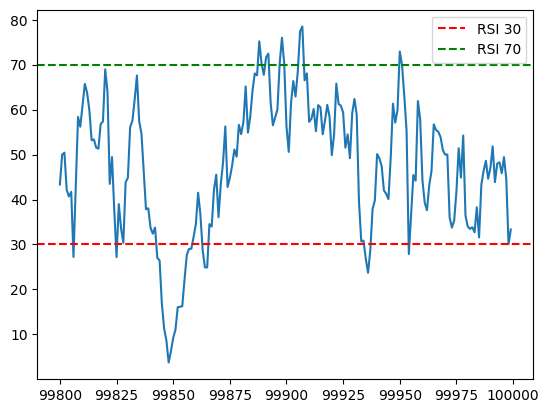

In [ ]:
# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(price_series, window=14):
    delta = price_series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi


# Calculate RSI and add it to the DataFrame
df['RSI'] = calculate_rsi(df["Open"])



# Plot the RSI with threshold lines at 30 and 70
plt.plot(df['RSI'][-200:])
plt.axhline(y=30, color='r', linestyle='--', label='RSI 30')
plt.axhline(y=70, color='g', linestyle='--', label='RSI 70')
plt.legend()
plt.show()

In [ ]:
# Prepare the input features (x) and target (y) for the model
x = df[["Open", "RSI"]]
y = df['Close']

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1 , shuffle=False,random_state = 0)

In [ ]:
# Scale the input features and target
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

train_x_scaled = scaler_x.fit_transform(train_x)
train_y_scaled = scaler_y.fit_transform(train_y.values.reshape(-1, 1))

# Prepare sequences of data for the LSTM model
x_train = []
y_train = []



for i in range(60, len(train_x_scaled)):
    x_train.append(train_x_scaled[i - 48:i, :])
    y_train.append(train_y_scaled[i])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Create the LSTM model
rnn = Sequential()

rnn.add(LSTM(units = 96 , return_sequences=True , input_shape = (x_train.shape[1], x_train.shape[2])))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 96 , return_sequences=True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 96 , return_sequences=True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units = 96))
rnn.add(Dropout(0.2))

rnn.add(Dense(units = 1))
rnn.compile(optimizer="adam" , loss='mean_squared_error')

# Train the LSTM model
rnn.fit(x_train , y_train ,epochs=30 , batch_size=32)

In [ ]:
# Scale the test data
test_x_scaled = scaler_x.transform(test_x)
test_y_scaled = scaler_y.transform(test_y.values.reshape(-1, 1))

# Prepare test sequences for prediction
x_test = []

for i in range(100, len(test_x_scaled)):
    x_test.append(test_x_scaled[i - 48:i, :])

x_test = np.array(x_test)

# Make predictions using the LSTM model
predicted_values_scaled = rnn.predict(x_test)

# Inverse scale the predicted values
predicted_values = scaler_y.inverse_transform(predicted_values_scaled)

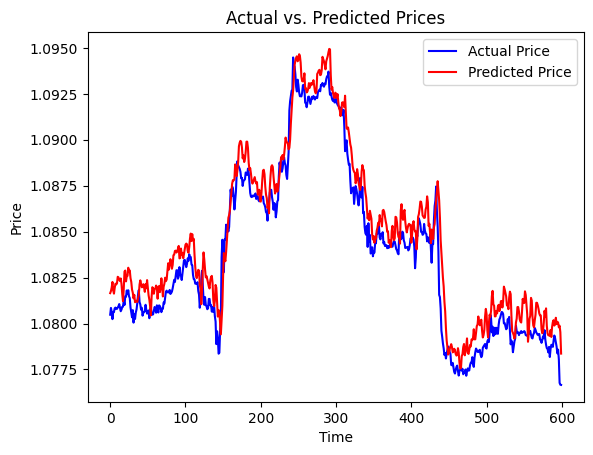

In [ ]:
# Select a portion of the test data for plotting
test_y_600 = test_y[-600:].reset_index(drop=True)

# Plot actual vs. predicted prices
plt.plot(test_y_600, label='Actual Price', color='blue')
plt.plot(predicted_values[-600:], label='Predicted Price', color='red')
plt.title("Actual vs. Predicted Prices")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.show()